In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import torch
# import new_myenv_withconstraints
import os
from model import DQN
from scipy import sparse
from Utils import *
import dgl
m = 100
steep = 1
MEMORY_CAPACITY = 16
actions_num = 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Using backend: pytorch[07:00:07] /opt/dgl/src/runtime/tensordispatch.cc:


In [2]:
%load_ext autoreload
%autoreload 2

## Make Dataset

In [3]:
import pandas as pd
train = pd.read_csv("../copy-malscan/split_train.csv")
train_path = "../flow_graph_exp/test_data.pkl"
df = open(train_path, "rb")
all_train_dict = pickle.load(df)
df.close()

In [4]:
adj_all = all_train_dict["noedge_weight"]
all_sha = all_train_dict["all_sha"]
node_all = all_train_dict["node_all"]
all_sen_idx = all_train_dict["all_sen_idx"]
all_label = all_train_dict["all_label"]
cons_fea = all_train_dict["cons_fea"]
cons = all_train_dict["cons"]

In [5]:
import sys
sys.path.append("/home2/ykli/workspace/flow_graph_exp/")
from Models import GCN_OUR
model_dir = "../flow_graph_exp/GCN_OUR_CON_NEW.pth"
model = GCN_OUR(10,64,1)
model.load_state_dict(torch.load(model_dir)["model"])
print('loaded model from: ', model_dir)
model.eval()

loaded model from:  ../flow_graph_exp/GCN_OUR_CON_NEW.pth


GCN_OUR(
  (conv1): GraphConv(in=10, out=64, normalization=none, activation=None)
  (conv2): GraphConv(in=64, out=64, normalization=none, activation=None)
  (conv3): GraphConv(in=64, out=64, normalization=none, activation=None)
  (classify): Linear(in_features=192, out_features=1, bias=True)
  (attn_fc): Linear(in_features=128, out_features=1, bias=False)
  (pooling): MaxPooling()
)

In [6]:
commufile = "../flow_graph_exp/all_commu_new.pkl"
with open(commufile, 'rb') as f:
    commu = pickle.load(f)

In [7]:
commu = np.array(commu)[train[train.test==True].index.values]

/tmp/ipykernel_3967246/1570822989.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  commu = np.array(commu)[train[train.test==True].index.values]


In [8]:
len(commu)

4004

In [9]:
train = pd.read_csv("../copy-malscan/split_train.csv")
test_df = train[train.test!=False]
with open("../flow_graph_exp/edge_weight_new_con.pkl", 'rb') as f:
    final_edge = pickle.load(f)
all_edge_weight = final_edge["all_edge_weight"]
all_sens_edge_weight = final_edge["all_sens_edge_weight"]
all_edge_weight = np.array(all_edge_weight)
all_ww = all_edge_weight[test_df.index.values]

/tmp/ipykernel_3967246/745853577.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_edge_weight = np.array(all_edge_weight)


In [10]:
test_sha256_list = all_sha
test_sensi_idx = all_sen_idx

In [11]:
from newmodels import DQN

In [12]:
dqn = DQN(
        encoder = model,
        states_dim=192,
        actions_num=3,
        memory_capacity=MEMORY_CAPACITY,
        learning_rate=0.01
)

In [13]:
with open('../APIGraph-master/src/res/method_entity_embedding_TransE.pkl', 'rb') as f:
    entity_embedding = pickle.load(f)

In [14]:
import our_myenv_withconstraints

Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'graph_tool', 'karateclub'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'leidenalg'}


In [15]:
from Utils import nettack_loss

In [ ]:
import dgl
g = adj_all[1]
g = dgl.from_scipy(g)
g.ndata["h"] = g.in_degrees().view(-1, 1).float()
c = cons[1]
env = new_myenv_withconstraints.CFGModifierEnvConstraints(target_graph = g,
                                                          label = 1,
                                                          constraints=c,
                                                          model = model,
                                                          lossfn = nettack_loss)
state, weight = env.reset()
# 初始状态为原始graph
action_type = dqn.choose_action(g.to(device), actions_num=actions_num)

In [16]:
from itertools import product
import copy
from tqdm import tqdm

correct_indices = []
# all_graphs = X
# all_labels = Y
all_g = []
all_pred = []

all_C = []
all_S = []
all_N = []
all_sens = []
all_L = []

model.cuda()

for i in tqdm(range(len(all_label))):
    sample = adj_all[i].T
    g = dgl.from_scipy(sample)
    num_nodes = sample.shape[0]
    nodes = node_all[i]
    cc = cons_fea[i]
    c = cons[i]
    fea = np.zeros((num_nodes, 10))
    for ks in cc:
        if ks>=num_nodes:
            continue
        temp_node = nodes[ks][1:-1].split(":")
        ids = temp_node[0] + "." + temp_node[1].strip().split(" ")[-1].split("(")[0]
        if ids in entity_embedding:
            fea[ks] = entity_embedding[ids]
    
    edge_weight  = all_ww[i]
    g.edata['h'] = torch.tensor(edge_weight).float()
    
    with torch.no_grad():
        # for baseline
        # fea = g.in_degrees().view(-1, 1).float()
        # g.ndata['h'] = fea
        g.ndata['h'] = torch.tensor(fea).float()
        # g = g.to("cuda")
        all_g.append(copy.deepcopy(g))
        preds = model.cpu()(g).detach()
        
    all_pred.append(preds)
    all_L.append(all_label[i])
    all_C.append(c)
    all_S.append(cc)
    all_N.append(nodes)

100%|██████████| 4004/4004 [00:34<00:00, 115.60it/s]


In [35]:
all_pred

tensor([6.3931e-04, 1.2532e-04, 5.1023e-03,  ..., 9.8941e-01, 2.9880e-02,
        9.1093e-04])

In [34]:
all_pred = torch.cat(all_pred).reshape(-1).sigmoid()
isright = np.array((all_pred>0.5).cpu())==np.array(all_L)
selected_indices = np.where(isright==True)[0]
correct_indices = selected_indices

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [36]:
malware_correct = [x for x in correct_indices if x not in np.where(np.array(all_L)==0)[0]]

In [37]:
len(correct_indices) / 4004

0.9597902097902098

In [20]:
from copy import deepcopy

In [21]:
model.cuda()

GCN_OUR(
  (conv1): GraphConv(in=10, out=64, normalization=none, activation=None)
  (conv2): GraphConv(in=64, out=64, normalization=none, activation=None)
  (conv3): GraphConv(in=64, out=64, normalization=none, activation=None)
  (classify): Linear(in_features=192, out_features=1, bias=True)
  (attn_fc): Linear(in_features=128, out_features=1, bias=False)
  (pooling): MaxPooling()
)

In [43]:
zidx = 5
adj_torch = adj_all[zidx].T
g = dgl.from_scipy(adj_torch)
num_nodes = adj_torch.shape[0]
nodes = node_all[zidx]
cc = cons_fea[zidx]
c = cons[zidx]

fea = np.zeros((num_nodes, 10))
for ks in cc:
    if ks>=num_nodes:
        continue
    temp_node = nodes[ks][1:-1].split(":")
    ids = temp_node[0] + "." + temp_node[1].strip().split(" ")[-1].split("(")[0]
    if ids in entity_embedding:
        fea[ks] = entity_embedding[ids]

edge_weight  = all_ww[zidx]
g = g.to(device)
g.ndata['h'] = torch.tensor(fea).float().cuda()
g.edata['h'] = torch.tensor(edge_weight).long().cuda()

In [27]:
model = model.cuda()

In [ ]:
constraints = cons[zidx]

In [46]:
env = our_myenv_withconstraints.CFGModifierEnvConstraints(target_graph = g,
                                                                  label = 1,
                                                                  constraints=constraints,
                                                                  model = model,
                                                                  lossfn = nettack_loss,
                                                         Tadj=adj_torch)

In [47]:
state, weight = env.reset()

In [51]:
cur_graph, reward, done, info, feat = env.step(action=2)

In [22]:
actions_num = 4
dqn = DQN(
        encoder = model,
        states_dim=192,
        actions_num=actions_num,
        memory_capacity=MEMORY_CAPACITY,
        learning_rate=0.01
)

In [23]:
save_path = "result_our_gcn_new_con"
check_folder(save_path)
seq_save_path = save_path + "/action_cons"
check_folder(seq_save_path)

In [79]:
# torch.hstack([g.in_edges(2,form="eid"), g.in_edges(2,form="eid")])

In [68]:
numss = []
for zidx in tqdm(range(0, len(test_sha256_list))):
    c = cons[zidx]
    numss.append(len(c))

100%|██████████| 4004/4004 [00:00<00:00, 1542856.52it/s]


(array([1.661e+03, 1.400e+02, 3.500e+01, 2.700e+01, 9.000e+00, 1.200e+01,
        7.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([    0. ,  1073.1,  2146.2,  3219.3,  4292.4,  5365.5,  6438.6,
         7511.7,  8584.8,  9657.9, 10731. ]),
 <BarContainer object of 10 artists>)

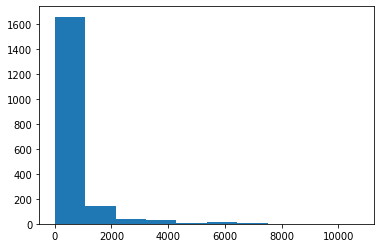

In [89]:
import matplotlib.pyplot as plt
plt.hist(np.array(numss)[malware_correct])

In [84]:
np.array(numss)[malware_correct].shape

(1895,)

In [85]:
ssss = np.array(numss)[malware_correct]

In [90]:
np.array(ssss)[np.array(ssss)<2000].shape

(1798,)

In [91]:
1798/1895

0.9488126649076517

In [108]:
len(malware_correct)

1895

In [111]:
nums = []
for zidx in malware_correct:
    nums.append(adj_all[zidx].shape[0])

In [113]:
len(np.array(nums)[np.array(nums)>6000])

131

In [33]:
save_path

'result_our_gcn_new_con'

In [ ]:
def log(mess):
    with open("logs/result_our_gcn_new_cons.txt","a") as f:
        f.write(mess)
        f.write("\n")
    f.close()
arl = []
attacks = []
success = []
cur_g = []
# for zidx in tqdm(range(1, len(test_sha256_list))):
for zidx in tqdm(malware_correct):
        if zidx<1734:
            continue
        log("\ncurrent test number:\t " + str(zidx))
        X_test_sha256 = test_sha256_list[zidx]
        if X_test_sha256 in arl:
            log("======continue======")
            print("skip:",X_test_sha256)
            continue
        
        lb = all_label[zidx]
        if lb==0:
            continue
        log(X_test_sha256)
        log("==== transfer adjacent matrix to triple set ====")
        X_test_am = adj_all[zidx].T

        if X_test_am.shape[0]>6000:
            print("======node number >6000======")
            continue

        ## sensitive API
        node_number = X_test_am.shape[0]
        # 转化为triple-邻接 去掉了自己到自己
        adj_torch = X_test_am

        # load model and calculate feature
        X_test_feature = None
        
        # 这里表示GCN算法
        # 改成转置
        g = dgl.from_scipy(adj_torch)

        num_nodes = node_number
        nodes = node_all[zidx]
        cc = cons_fea[zidx]
        c = cons[zidx]
        fea = np.zeros((num_nodes, 10))
        
        for ks in cc:
            if ks>=num_nodes:
                continue
            temp_node = nodes[ks][1:-1].split(":")
            ids = temp_node[0] + "." + temp_node[1].strip().split(" ")[-1].split("(")[0]
            if ids in entity_embedding:
                fea[ks] = entity_embedding[ids]
        
        edge_weight  = all_ww[zidx]
        # g = g.to(device)
        g.ndata['h'] = torch.tensor(fea).float()
        g.edata['h'] = torch.tensor(edge_weight).long()
        # g.ndata["h"] = g.in_degrees().view(-1, 1).float()
        g = g.to(device)
        y, _ , init_feat = model.cuda()(g,isreturn=True)
        y = 1 if y.sigmoid()>0.5 else 0
        
        # 如果距离该样本最近的样本是良性样本
        if y != 1:
            print('==== data cannot be correctly classified as malware ====\t')
            continue
        
        # y_test = 0
        # begin train something
        log('\t ==== get the nearest neighbors for optimization ====')
        # load constraints
        log('\t ===== loading constraints =====')

        # constraints表示可以修改的结点
        # 1表示可以修改
        attacks.append(zidx)
        
        constraints = cons[zidx]
        
        if len(constraints) == 0:
            continue
            
        if len(constraints)>2000:
            constraints_temp = np.random.choice(constraints, 2000, replace=False)
        else:
            constraints_temp = constraints
        
        env = our_myenv_withconstraints.CFGModifierEnvConstraints(target_graph = g,
                                                                  label = 1,
                                                                  constraints=constraints_temp,
                                                                  model = model,
                                                                  lossfn = nettack_loss,
                                                                  Tadj = adj_torch)
        
        log('\t ==== Collecting experience ... ====')
        flag = 0
        # 每个样本30个episode
        for i_episode in range(1):
            actions_store = []
            log(f"reset: {i_episode}")
            # 给初始graph
            state, weight = env.reset()
            ep_r = 0
            count = 0
            ## 不断选取动作 获取reward和状态
            ## state为graph
            # cur_graph = deepcopy(g)
            cur_graph = g
            while True:
                log("current round:\t" + str(count) + "\t==========")
                if dqn.memory_counter <= MEMORY_CAPACITY:
                    action_type = np.random.randint(actions_num)
                else:
                    # 动作选择
                    # state就是从graph
                    action_type = dqn.choose_action(init_feat, actions_num=actions_num)
                
                ## 在这里直接更新graph
                # try:
                cur_graph, reward, done, info, feat = env.step(action=action_type)
                # except:
                #     break
                # feat = feat.reshape(-1)
                
                log('reward：'+str(reward))
                
                if type(action_type) is np.ndarray:
                    action_type = action_type[0]

                # action包括动作类型和info
                action = np.array([action_type] + info)
                dqn.store_transition(init_feat.reshape(-1), action, reward, feat.reshape(-1), MEMORY_CAPACITY)
                # log("\t", action.tolist())
                log("\t" + str(action.tolist()))
                actions_store.append(action.tolist())
                ep_r += reward
                
                # 存储到一定次数 就更新一下
                if dqn.memory_counter > MEMORY_CAPACITY:
                    dqn.learn(MEMORY_CAPACITY, 16, N_STATES=init_feat.shape[1])
                    # 如果修改成功
                    if done:
                        log(f"Ep:{i_episode} | Ep_reward: {round(ep_r, 2)}")
                # 如果修改成功
                if done:
                    success.append(zidx)
                    # 如果修改成功时的count小于5
                    if count<5:
                        flag = 1
                    # check_label, min_dist = find_nn_torch(state_, train_feature_torch, train_label_torch, k=1)
                    check_label = model.cpu()(cur_graph.cpu())
                    check_label = 1 if check_label.sigmoid()>0.5 else 0
                    # check一下距离最近的label
                    if check_label == 1:
                        print("something went wrong")
                    # 保存
                    action_path = seq_save_path + "/" + X_test_sha256 + "action_list" + str(i_episode) + ".txt"

                    file = open(action_path, 'w')
                    for az in actions_store:
                        file.write(str(az))
                        file.write('\n')
                    file.write(str(done))
                    file.write('\n')
                    file.close()
                    # 保存当前修改后的graph
                    # graph_path = seq_save_path + "/final_graph" + str(i_episode)+"_" + X_test_sha256 + ".npy"
                    # np.save(graph_path, cur_graph)
                    cur_g.append(cur_graph)
                    print('!!!! finish')
                    log('!!!! finish')
                    pickle.dump(cur_g, open(os.path.join(save_path, f'adv_example.pickle'), 'wb'))
                    break
                    
                if count > 500:
                    break
                # s = state_
                # cur_graph = cur_graph_
                init_feat = feat
                count += 1
            # 在5次以内完成攻击 就直接break
            if flag == 1:
                break

In [6]:
# 227

In [122]:
89/301

0.2956810631229236

In [25]:
len(success)

344

In [26]:
len(attacks)

624

In [39]:
32/67

0.47761194029850745

In [36]:
10/29

0.3448275862068966

In [61]:
8/46

0.17391304347826086

In [57]:
19/46

0.41304347826086957

In [97]:
105/301

0.3488372093023256

In [120]:
89/301

0.2956810631229236

In [81]:
len(success)

18

In [82]:
len(attacks)

45

In [162]:
4769 in cs1

False

In [196]:
len(success_idx)

42

In [330]:
iid = success_idx[-10]
all_sha[iid]

'AE4A3AD3758E70407C90D4A4353411B33DAD777091D56FFC48C195269EE45F93'

In [358]:
nd = node_all[iid]

In [360]:
sses = all_sen_idx[iid]
sses = sses[sses!=-1]

In [293]:
# get deviceid 799

799

In [355]:
aa = []
bb = []
for kk, iid in enumerate(success_idx):
    t1 = adj_all[iid]
    t1 = dgl.from_scipy(t1.T)
    t2 = cur_g[adv_idx[kk]]
    aa.append(t1.out_degrees().numpy().max())
    bb.append(t2.out_degrees().numpy().max())

In [332]:
import seaborn as sns

In [218]:
def iscommu(a,com):
    ss = []
    for aa in a:
        for k,m in enumerate(com):
            if aa in m:
                ss.append(k)
    return ss

In [230]:
G = t2.to_networkx()
# G = nx.from_scipy_sparse_matrix(matrix)
# coms = algorithms.infomap(G, weight='weight', resolution=1., randomize=False)
coms = algorithms.infomap(G)
advcommu = coms.communities

In [222]:
# sel = 1
# ori = ori_attack[sel]
# adp = advp[sel]
# commu = COM[attack_index[sel]]
# ed = len(adp.edges()[0]) - len(ori.data)
# edge1 = adp.edges()[0][-ed:]
# edge2 = adp.edges()[1][-ed:]
edge1 =pp[:,2]
edge2 =pp[:,3]

senss = all_sen_idx[iid]

print(iscommu(edge1, com))
print(iscommu(edge2, com))

maps = {}
for k, mm in enumerate(com):
    if np.isin(mm, senss).sum()>0:
        maps[k] = 1
    else:
        maps[k] = 0
        
def check(m):
    return maps[m]

print(list(map(check,iscommu(edge1, com))))
print(list(map(check,iscommu(edge2, com))))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 4]
[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
edge1 =pp[:,2]
edge2 =pp[:,3]

senss = all_sen_idx[iid]

print(iscommu(edge1, advcommu))
print(iscommu(edge2, advcommu))

maps = {}
for k, mm in enumerate(com):
    if np.isin(mm, senss).sum()>0:
        maps[k] = 1
    else:
        maps[k] = 0
        
def check(m):
    return maps[m]

print(list(map(check,iscommu(edge1, advcommu))))
print(list(map(check,iscommu(edge2, advcommu))))

In [ ]:
from itertools import product
graph = adj_all[success[0]]
graph = dgl.from_scipy(graph.T)
n = graph.number_of_nodes()
m = graph.number_of_edges()
cs1 = cons[success[0]]
consall = cons_fea[success[0]]

to_add_u = []
to_add_v = []
for u, v in product(cs1,cs1):
# for u, v in product(range(n), range(n)):
    if u != v and not graph.has_edges_between(u, v):
        to_add_u.append(u)
        to_add_v.append(v)
to_add_cons_u = []
to_add_cons_v = []
# cons->other
# 由于进行了转置 other-> cons
for u in range(n):
    if u in consall:
        continue
    for v in cs1:
        if u not in cs1:
            if not graph.has_edges_between(u, v):
                to_add_cons_u.append(u)
                to_add_cons_v.append(v)
# change edge_weights
# cur_graph的add edge均需要添加edata为1
# ori_edge_w = graph.edata["h"]
edge_weights = torch.hstack((ori_edge_w, torch.zeros(len(to_add_u)),torch.zeros(len(to_add_cons_u)) ))
# edge_weights.requires_grad = True
# graph.add_edges(to_add_u, to_add_v)
# graph.add_edges(to_add_cons_u, to_add_cons_v)

In [154]:
# indes = np.isin(graph.edges()[0].numpy(),cs1) & (np.isin(graph.edges()[0].numpy(),cs1))
# edd = torch.cat([graph.edges()[0].reshape(-1,1), graph.edges()[1].reshape(-1,1)],dim=1)
# edd = edd.numpy()

In [144]:
tt = adj_all[success[0]].todense()
tt = np.array(tt)
aaa = tt[cs1][:,cs1]
aaa[range(aaa.shape[0]),range(aaa.shape[0])] = 1
to_add_u = cs1[np.where(aaa==0)[0]].shape
to_add_v = cs1[np.where(aaa==0)[0]].shape

In [176]:
other = np.arange(n)[~np.isin(range(n), cs1)]

In [ ]:
to_add_u1 = []
to_add_v1 = []
for u, v in product(cs1,cs1):
    if u != v and not graph.has_edges_between(u, v):
        to_add_u.append(u)
        to_add_v.append(v)
        
to_add_cons_u = []
to_add_cons_v = []

# cons->other
# 由于进行了转置 other-> cons

In [196]:
tt = adj_all[success[0]].T.todense()
tt = np.array(tt)

In [ ]:
bbb = tt[other][:,cs1]
to_add_u = cs1[np.where(aaa==0)[0]].shape
to_add_v = cs1[np.where(aaa==0)[0]].shape

In [199]:
bbb = tt[cs1][:,other]

In [200]:
bbb.shape

(382, 1966)

In [201]:
np.where(bbb==0)[0].shape

(750604,)

In [ ]:
to_add_cons_uss = other[np.where(bbb==0)[0]]

In [203]:
to_add_cons_uss = cs1[np.where(bbb==0)[1]]

IndexError: index 382 is out of bounds for axis 0 with size 382

In [113]:
cur_g[2]

Graph(num_nodes=1914, num_edges=6623,
      ndata_schemes={'h': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(), dtype=torch.int64)})

In [114]:
all_g[success[2]]

Graph(num_nodes=1907, num_edges=6519,
      ndata_schemes={'h': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(), dtype=torch.float32)})

In [124]:
cur_g[0]

Graph(num_nodes=825, num_edges=1556,
      ndata_schemes={'h': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(), dtype=torch.int64)})

In [122]:
adj_all[success[0]]

<825x825 sparse matrix of type '<class 'numpy.int64'>'
	with 1547 stored elements in COOrdinate format>

HRAT

In [39]:
adv_path = "result_our_gcn_con_new/adv_example.pickle"
advvv = open(adv_path, "rb")
advsample = pickle.load(advvv)
advvv.close()

In [48]:
shaa = os.listdir("result_our_gcn_con_new/action_cons/")

In [62]:
train_path = "../rewiring/COMMU_GCN_OUR_ATTACK.pkl"
df = open(train_path, "rb")
success = pickle.load(df)
df.close()

In [65]:
success[11]

[Graph(num_nodes=825, num_edges=1630,
       ndata_schemes={'h': Scheme(shape=(10,), dtype=torch.float64)}
       edata_schemes={'h': Scheme(shape=(), dtype=torch.float64)})]

In [133]:
train_path = "../grabnel/grabnel-main/src/output/our_gcn_bo/trial-0-stats.pickle"
df = open(train_path, "rb")
ads = pickle.load(df)
df.close()

In [134]:
is_successful = ads["is_successful"]
selected_indices = ads["selected_samples"]

In [136]:
np.sum(is_successful)

27

In [141]:
np.sum(ads["is_attacked"])

181

In [112]:
train_path = "../grabnel/grabnel-main/src/output/our_gcn_con_new/trial-0-adv_example_test.pickle"
df = open(train_path, "rb")
advsp = pickle.load(df)
df.close()

In [111]:
success_index = np.where(np.array(is_successful)==1)
final_index = selected_indices[success_index]

In [113]:
from cdlib import algorithms
adv_all_edge_weight = []
adv_all_sen_edge_weight = []
for kk, ss in tqdm(enumerate(final_index)):
    # adv = success[ss][0].cpu()
    adv = advsp[kk].cpu()
    num_nodes = adv.num_nodes()
    n = node_all[ss]
    cf = cons_fea[ss]
    cccc = cons[ss]
    sens_temp = all_sen_idx[ss]
    # sens_temp = sens_temp[sens_temp!=-1]
    
    ## community detection
    G = adv.to_networkx()
    # G = nx.from_scipy_sparse_matrix(matrix)
    # coms = algorithms.infomap(G, weight='weight', resolution=1., randomize=False)
    coms = algorithms.infomap(G)
    advcommu = coms.communities
    
    bip  = advcommu
    # 属于哪一个commu以及属于benign还是malicious
    tempcommu = np.zeros(num_nodes)
    tempsens = np.zeros(num_nodes)
    
    for c, v_c in enumerate(bip):
        tempcommu[v_c] = c
            
    edges = torch.cat([adv.edges()[0].reshape(-1,1),adv.edges()[1].reshape(-1,1)],dim=1)            
    edges = edges.cpu().numpy()
    indexx = np.isin(edges[:,0],cccc)&np.isin(edges[:,1],cccc)
    edges = edges[indexx,:]
    final_weight = np.ones(adv.num_edges()) 
    
    edge_weight = []
    sens_edge_weight = []
    # for v, w in zip(adv.edges()[0], adv.edges()[1]):
    for v, w in zip(edges[:,0], edges[:,1]):
        if tempcommu[v] == tempcommu[w]:
            edge_weight.append(1)
        else:
            edge_weight.append(0)
            
    if len(edge_weight)>0:
        final_weight[indexx] = np.array(edge_weight)
        
    adv_all_edge_weight.append(final_weight)
    adv_all_sen_edge_weight.append(sens_edge_weight)

92it [00:14,  6.45it/s]


In [30]:
from cdlib import algorithms
adv_all_edge_weight = []
adv_all_sen_edge_weight = []

for kk, ss in tqdm(enumerate(success)):
    adv = cur_g[kk].cpu()
    num_nodes = adv.num_nodes()
    n = node_all[ss]
    cf = cons_fea[ss]
    cccc = cons[ss]
    sens_temp = all_sen_idx[ss]
    # sens_temp = sens_temp[sens_temp!=-1]
    
    ## community detection
    G = adv.to_networkx()
    # G = nx.from_scipy_sparse_matrix(matrix)
    # coms = algorithms.infomap(G, weight='weight', resolution=1., randomize=False)
    coms = algorithms.infomap(G)
    advcommu = coms.communities
    
    bip  = advcommu
    # 属于哪一个commu以及属于benign还是malicious
    tempcommu = np.zeros(num_nodes)
    tempsens = np.zeros(num_nodes)
    
    for c, v_c in enumerate(bip):
        tempcommu[v_c] = c
        if np.isin(sens_temp,v_c).sum()>0:
            tempsens[v_c] = 1
            
    edges = torch.cat([adv.edges()[0].reshape(-1,1),adv.edges()[1].reshape(-1,1)],dim=1)            
    edges = edges.cpu().numpy()
    indexx = np.isin(edges[:,0],cccc)&np.isin(edges[:,1],cccc)
    edges = edges[indexx,:]
    final_weight = np.ones(adv.num_edges()) 
    
    edge_weight = []
    sens_edge_weight = []
    # for v, w in zip(adv.edges()[0], adv.edges()[1]):
    for v, w in zip(edges[:,0], edges[:,1]):

        if tempcommu[v] == tempcommu[w]:
            edge_weight.append(1)
        else:
            edge_weight.append(0)
        
        if tempsens[v] == tempsens[w]:
            sens_edge_weight.append(1)
        else:
            sens_edge_weight.append(0)
    if len(edge_weight)>0:
        final_weight[indexx] = np.array(edge_weight)
        
    adv_all_edge_weight.append(final_weight)
    adv_all_sen_edge_weight.append(sens_edge_weight)

344it [01:01,  5.59it/s]


In [114]:
# 计算
fn_pred = []
for kk,adv in enumerate(advsp):
    with torch.no_grad():
        # adv = success[adv][0].cpu()
        adv.edata["h"] = torch.tensor(adv_all_edge_weight[kk])
        # adv = adv.to("cuda")
        preds = model.cpu()(adv).detach()
        fn_pred.append(preds)

In [115]:
torch.sum(torch.cat(fn_pred).sigmoid().reshape(-1)<0.5)

tensor(28)

In [130]:
np.sum(ads["is_attacked"])

442

In [99]:
success_idx = np.array(success)[(torch.cat(fn_pred).sigmoid().reshape(-1)>0.5).detach().cpu().numpy()]

In [104]:
adv_idx = np.arange(len(success))[(torch.cat(fn_pred).sigmoid().reshape(-1)>0.5).detach().cpu().numpy()]

In [32]:
np.sum((torch.cat(fn_pred).sigmoid().reshape(-1)>0.5).detach().cpu().numpy() != all_label[success])

343

In [1]:
42/362

0.11602209944751381

In [ ]:
# 147

In [19]:
zidx

300

In [6]:
dqn.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

In [7]:
save_dict = {
    "optimizer" : dqn.optimizer.state_dict(),
    "eval_net" : dqn.eval_net.state_dict(),
    "target_net" : dqn.target_net.state_dict()
}
torch.save(save_dict,"our_gcn.pth")

In [ ]:
# 场景  白盒攻击
# 攻击时间长